In [142]:
import pandas as pd
import geopandas as gpd
import numpy as np
import esda

import spreg
import statsmodels.api as sm

import mapclassify
import seaborn as sns
import libpysal as lps
import matplotlib.pyplot as plt

from libpysal.weights.contiguity import Queen
from sklearn.metrics import mean_squared_error as mse

from pysal.model.mgwr.sel_bw import Sel_BW
from pysal.model.mgwr.gwr import GWR
from pysal.model.mgwr.gwr import MGWR
from mgwr.utils import shift_colormap, truncate_colormap

# data

<AxesSubplot:>

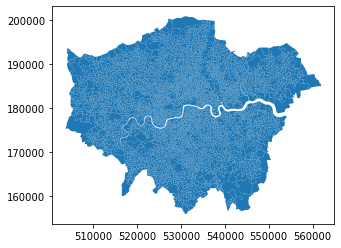

In [90]:
# data of map
lsoas=gpd.read_file('./lsoa_IMD_airbnb_housing/lsoa_IMD_airbnb_housing.shp')
lsoas.plot()

In [79]:
lsoas

Code                       Area                  Year      Value  \
0     E01000001        City of London 001A  Year ending Dec 2017  1204928.0   
1     E01000002        City of London 001B  Year ending Dec 2017   991549.0   
2     E01000003        City of London 001C  Year ending Dec 2017   913007.0   
3     E01000005        City of London 001E  Year ending Dec 2017        0.0   
4     E01000006  Barking and Dagenham 016A  Year ending Dec 2017   354300.0   
...         ...                        ...                   ...        ...   
4830  E01033742             Greenwich 007F  Year ending Dec 2017   315553.0   
4831  E01033743             Greenwich 002H  Year ending Dec 2017   286682.0   
4832  E01033744             Greenwich 007G  Year ending Dec 2017   294493.0   
4833  E01033745             Greenwich 002I  Year ending Dec 2017   310000.0   
4834  E01033746             Greenwich 038E  Year ending Dec 2017   695880.0   

     Measure                   LSOA11NM  USUALRES  HHOLDRES  COMESTRES  \
0       Mean        City of London 001A      1465      1465          0   
1       Mean        City of London 001B      1436      1436          0   
2       Mean        City of London 001C      1346      1250         96   
3       Mean        City of London 001E       985       985          0   
4       Mean  Barking and Dagenham 016A      1703      1699          4   
...      ...                        ...       ...       ...        ...   
4830    Mean             Greenwich 007F      1352      1352          0   
4831    Mean             Greenwich 002H      2038      2038          0   
4832    Mean             Greenwich 007G      1845      1728        117   
4833    Mean             Greenwich 002I      1820      1820          0   
4834    Mean             Greenwich 038E      1464      1436         28   

      POPDEN  ...  EduScore  HeaScore  CriScore  BaHScore  EnvScore  \
0      112.9  ...       0.0      -1.7      -2.0      29.5      31.9   
1       62.9  ...       0.1      -1.1      -2.3      24.4      23.1   
2      227.7  ...       5.8      -0.1      -1.0      40.1      40.5   
3       52.0  ...      22.3      -0.1      -1.3      39.9      29.0   
4      116.2  ...      14.8      -0.4      -0.1      45.2      26.9   
...      ...  ...       ...       ...       ...       ...       ...   
4830   107.6  ...       7.8      -0.4      -0.2      40.5      12.5   
4831    20.4  ...       9.2      -0.2       0.2      50.3      11.9   
4832   125.8  ...      17.9       0.9       0.4      37.3      14.2   
4833    32.3  ...       9.8      -0.2      -0.3      45.1      14.8   
4834   115.3  ...       6.4      -0.4       0.7      24.0      45.7   

      Mean Price  Small Host  Multiple L  Property C  \
0     159.083333         4.0         8.0        12.0   
1     155.000000         8.0         6.0        14.0   
2      93.466667        10.0         5.0        15.0   
3     151.324074        33.0        75.0       108.0   
4      57.000000         2.0         2.0         4.0   
...          ...         ...         ...         ...   
4830   53.076923        12.0         1.0        13.0   
4831  121.666667         4.0         2.0         6.0   
4832  101.318182        11.0        11.0        22.0   
4833   98.285714         6.0         1.0         7.0   
4834  244.111111         8.0         1.0         9.0   

                                               geometry  
0     POLYGON ((532105.330 182017.386, 532162.728 18...  
1     POLYGON ((532747.048 181793.042, 532671.921 18...  
2     POLYGON ((532135.385 182204.275, 532158.489 18...  
3     POLYGON ((533808.170 180773.910, 533649.287 18...  
4     POLYGON ((545122.084 184321.013, 545271.951 18...  
...                                                 ...  
4830  POLYGON ((544642.760 179830.773, 544766.392 17...  
4831  POLYGON ((546579.271 181103.898, 546687.117 18...  
4832  POLYGON ((544536.564 179453.221, 544602.707 17...  
4833  POLYGON ((546415.827 180158.362, 546320.798 18...  
4834  POL

In [80]:
lsoas.columns

Index(['Code', 'Area', 'Year', 'Value', 'Measure', 'LSOA11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'IMDScore',
       'IncScore', 'EmpScore', 'EduScore', 'HeaScore', 'CriScore', 'BaHScore',
       'EnvScore', 'Mean Price', 'Small Host', 'Multiple L', 'Property C',
       'geometry'],
      dtype='object')

In [91]:
# drop the columns not needed
lsoas.drop(['Area', 'Year', 'Value', 'POPDEN', 'Measure', 'LSOA11NM', 'HHOLDRES', 'COMESTRES', 'HHOLDS', 'AVHHOLDSZ', 'IMDScore', 'EmpScore', 'HeaScore', 'CriScore', 'Mean Price', 'Small Host', 'Multiple L', 'Property C'], axis=1, inplace=True)
lsoas

Code  USUALRES  IncScore  EduScore  BaHScore  EnvScore  \
0     E01000001      1465       0.0       0.0      29.5      31.9   
1     E01000002      1436       0.0       0.1      24.4      23.1   
2     E01000003      1346       0.1       5.8      40.1      40.5   
3     E01000005       985       0.2      22.3      39.9      29.0   
4     E01000006      1703       0.1      14.8      45.2      26.9   
...         ...       ...       ...       ...       ...       ...   
4830  E01033742      1352       0.1       7.8      40.5      12.5   
4831  E01033743      2038       0.1       9.2      50.3      11.9   
4832  E01033744      1845       0.2      17.9      37.3      14.2   
4833  E01033745      1820       0.2       9.8      45.1      14.8   
4834  E01033746      1464       0.1       6.4      24.0      45.7   

                                               geometry  
0     POLYGON ((532105.330 182017.386, 532162.728 18...  
1     POLYGON ((532747.048 181793.042, 532671.921 18...  
2     POLYGON ((532135.385 182204.275, 532158.489 18...  
3     POLYGON ((533808.170 180773.910, 533649.287 18...  
4     POLYGON ((545122.084 184321.013, 545271.951 18...  
...                                                 ...  
4830  POLYGON ((544642.760 179830.773, 544766.392 17...  
4831  POLYGON ((546579.271 181103.898, 546687.117 18...  
4832  POLYGON ((544536.564 179453.221, 544602.707 17...  
4833  POLYGON ((546415.827 180158.362, 546320.798 18...  
4834  POLYGON ((538140.138 177319.110, 538129.314 17...  

[4835 rows x 7 columns]

In [68]:
# data of vehicle
data_vehicle = pd.read_csv('./data/vehicle.csv')
data_vehicle['vehicle_num'] = data_vehicle['1_car_or_van'] + 2*data_vehicle['2_cars_or_vans'] + 3*data_vehicle['3_cars_or_vans'] + 4*data_vehicle['4_or_more_cars or_vans']
data_vehicle = data_vehicle[['11lsoa', 'vehicle_num']]
data_vehicle = data_vehicle.rename(columns={'11lsoa':'LSOA'})
data_vehicle

LSOA  vehicle_num
0                                             E01000907        286.0
1                                             E01000908        393.0
2                                             E01000909        572.0
3                                             E01000912        301.0
4                                             E01000913        888.0
...                                                 ...          ...
4838                                                NaN          NaN
4839  In order to protect against disclosure of pers...          NaN
4840  have been swapped between different geographic...          NaN
4841  be affected, particularly small counts at the ...          NaN
4842  be affected, particularly small counts at the ...          NaN

[4843 rows x 2 columns]

In [70]:
# data of parks
data_parks = pd.read_csv('./data/parks.csv')
data_parks = data_parks[['LSOA code', 'Average combined size of Parks or Public Gardens within 1,000 m radius (m2)', 'Average number of Parks or Public Gardens within 1,000 m radius']]
data_parks = data_parks.rename(columns={'Average combined size of Parks or Public Gardens within 1,000 m radius (m2)':'park_size_avg(m2)', 'Average number of Parks or Public Gardens within 1,000 m radius':'park_num_avg'})
data_parks

LSOA code  park_size_avg(m2)  park_num_avg
0      E01000001       2.410456e+04     10.410000
1      E01000002       1.846643e+04      9.990000
2      E01000003       3.094224e+04      9.530000
3      E01000005       4.713426e+04     12.240000
4      E01000006       4.742585e+05      4.570000
...          ...                ...           ...
41389  W01001954       5.762922e+05      3.021739
41390  W01001955       4.215282e+04      3.992593
41391  W01001956       2.943914e+06      1.000000
41392  W01001957       3.376665e+04      3.434783
41393  W01001958       1.505597e+04      2.625000

[41394 rows x 3 columns]

In [95]:
# combine data
merge1 = pd.merge(lsoas, data_vehicle, how='left', left_on='Code', right_on='LSOA')
merge2 = pd.merge(merge1, data_parks, how='left', left_on='Code', right_on='LSOA code')
merge2.drop(['LSOA', 'LSOA code'], axis=1, inplace=True)
merge2 = merge2[['Code', 'EnvScore', 'IncScore', 'EduScore', 'USUALRES', 'vehicle_num', 'park_num_avg', 'geometry']]
merge2

Code  EnvScore  IncScore  EduScore  USUALRES  vehicle_num  \
0     E01000001      31.9       0.0       0.0      1465        452.0   
1     E01000002      23.1       0.0       0.1      1436        428.0   
2     E01000003      40.5       0.1       5.8      1346        180.0   
3     E01000005      29.0       0.2      22.3       985        124.0   
4     E01000006      26.9       0.1      14.8      1703        493.0   
...         ...       ...       ...       ...       ...          ...   
4830  E01033742      12.5       0.1       7.8      1352        390.0   
4831  E01033743      11.9       0.1       9.2      2038        522.0   
4832  E01033744      14.2       0.2      17.9      1845        429.0   
4833  E01033745      14.8       0.2       9.8      1820        548.0   
4834  E01033746      45.7       0.1       6.4      1464        421.0   

      park_num_avg                                           geometry  
0        10.410000  POLYGON ((532105.330 182017.386, 532162.728 18...  
1         9.990000  POLYGON ((532747.048 181793.042, 532671.921 18...  
2         9.530000  POLYGON ((532135.385 182204.275, 532158.489 18...  
3        12.240000  POLYGON ((533808.170 180773.910, 533649.287 18...  
4         4.570000  POLYGON ((545122.084 184321.013, 545271.951 18...  
...            ...                                                ...  
4830      2.733333  POLYGON ((544642.760 179830.773, 544766.392 17...  
4831      1.250000  POLYGON ((546579.271 181103.898, 546687.117 18...  
4832      2.419355  POLYGON ((544536.564 179453.221, 544602.707 17...  
4833      2.300000  POLYGON ((546415.827 180158.362, 546320.798 18...  
4834      5.967742  POLYGON ((538140.138 177319.110, 538129.314 17...  

[4835 rows x 8 columns]

In [72]:
len(merge2)

4835

# Multivariate Regression

In [47]:
y = np.array(merge2['EnvScore'])
y.shape = (len(merge2),1)

In [96]:
X = []
X.append(merge2['IncScore'])
X.append(merge2['EduScore'])
X.append(merge2['USUALRES'])
X.append(merge2['vehicle_num'])
X.append(merge2['park_num_avg'])
X=np.array(X).T
X.shape

(4835, 5)

In [97]:
ols = spreg.OLS(y, X, name_y='Environment Score',
                            name_x=['Income Deprivation', 'Education Deprivation', 'Number of Vehicle', 'Resident Population','Average Park Number'],
                            name_ds='London Environment', white_test=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :London Environment
Weights matrix      :        None
Dependent Variable  :Environment Score                Number of Observations:        4835
Mean dependent var  :     29.2102                Number of Variables   :           6
S.D. dependent var  :     10.8933                Degrees of Freedom    :        4829
R-squared           :      0.4240
Adjusted R-squared  :      0.4234
Sum squared residual:  330410.127                F-statistic           :    710.9068
Sigma-square        :      68.422                Prob(F-statistic)     :           0
S.E. of regression  :       8.272                Log likelihood        :  -17073.184
Sigma-square ML     :      68.337                Akaike info criterion :   34158.369
S.E of regression ML:      8.2666                Schwarz criterion     :   34197.270

------------------------------------------------------------------

In [98]:
X2 = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model_c = sm.OLS(y, X2).fit() ## sm.OLS(output, input)
predictions = model_c.predict(X2)

# Print out the statistics
print(model_c.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     710.9
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:28:54   Log-Likelihood:                -17073.
No. Observations:                4835   AIC:                         3.416e+04
Df Residuals:                    4829   BIC:                         3.420e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8780      0.933     42.733      0.0

# Spatial Regression

In [51]:
w_queen=Queen.from_shapefile('./lsoa_IMD_airbnb_housing/lsoa_IMD_airbnb_housing.shp')
w_queen

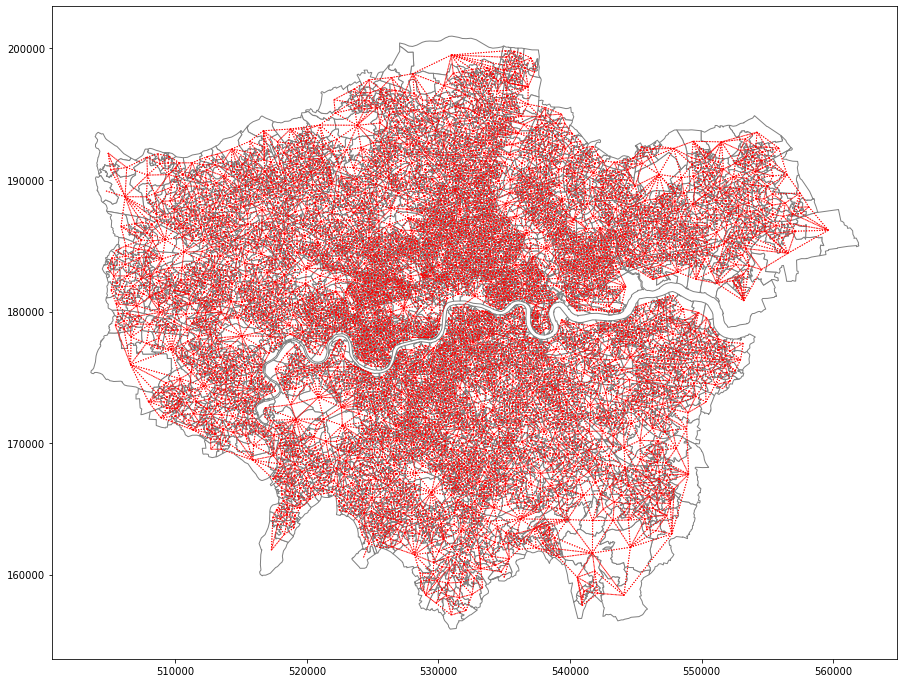

In [53]:
ax = merge2.plot(edgecolor='grey', facecolor='w', figsize=(20, 12))
f,ax = w_queen.plot(merge2, ax=ax,
                    edge_kws=dict(color='r', linestyle=':', linewidth=1),
                    node_kws=dict(marker=''))

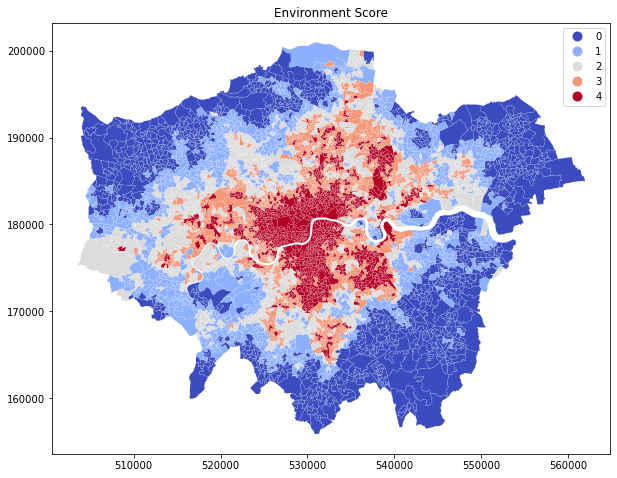

In [143]:
w_queen.transform = 'r'
price_Lag = lps.weights.lag_spatial(w_queen, merge2['EnvScore']) #spatial lag of the variable
price_LagQ5 = mapclassify.Quantiles(price_Lag, k=5)

f, ax = plt.subplots(1, figsize=(10, 8))
merge2.assign(cl_lag=price_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Environment Score')
plt.show()

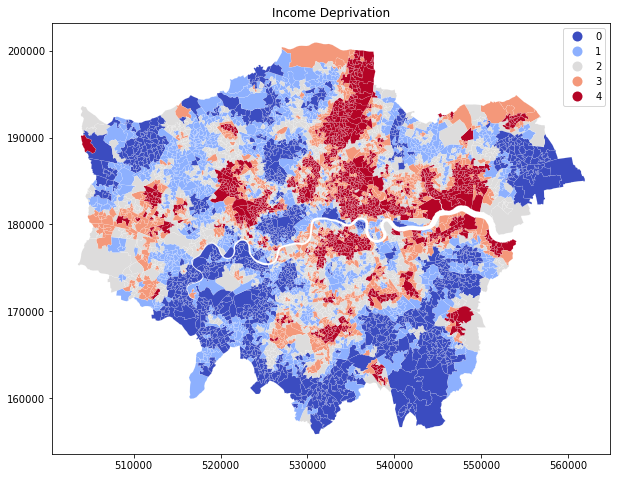

In [146]:
w_queen.transform = 'r'
price_Lag = lps.weights.lag_spatial(w_queen, merge2['IncScore']) #spatial lag of the variable
price_LagQ5 = mapclassify.Quantiles(price_Lag, k=5)

f, ax = plt.subplots(1, figsize=(10, 8))
merge2.assign(cl_lag=price_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Income Deprivation')
plt.show()

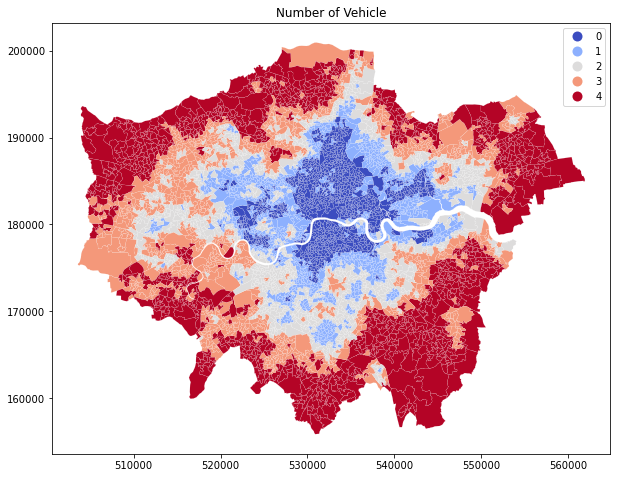

In [147]:
w_queen.transform = 'r'
price_Lag = lps.weights.lag_spatial(w_queen, merge2['vehicle_num']) #spatial lag of the variable
price_LagQ5 = mapclassify.Quantiles(price_Lag, k=5)

f, ax = plt.subplots(1, figsize=(10, 8))
merge2.assign(cl_lag=price_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Number of Vehicle')
plt.show()

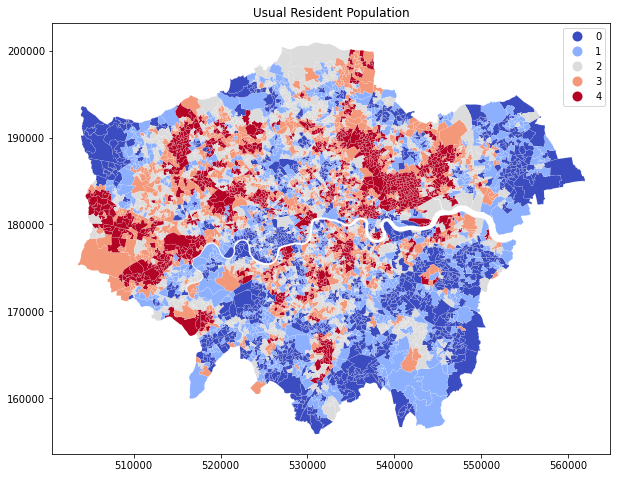

In [148]:
w_queen.transform = 'r'
price_Lag = lps.weights.lag_spatial(w_queen, merge2['USUALRES']) #spatial lag of the variable
price_LagQ5 = mapclassify.Quantiles(price_Lag, k=5)

f, ax = plt.subplots(1, figsize=(10, 8))
merge2.assign(cl_lag=price_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Usual Resident Population')
plt.show()

In [54]:
mi = esda.Moran(merge2['EnvScore'], w_queen, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.6024 
The Expected Value for Statistic I is: -0.0002 
The Significance Test Value is: 0.0000


Text(0.5, 0, "Moran's I")

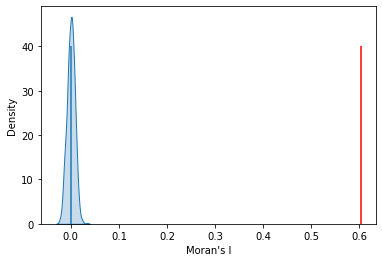

In [140]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

## Spatial Lag Model

In [99]:
spat_lag = spreg.ML_Lag(y,X,w_queen,name_y='Environment Score',
                  name_x=['Income Deprivation', 'Education Deprivation', 'Number of Vehicle', 'Resident Population','Average Park Number'],
                  name_w='w_queen', name_ds='London Environment')
print(spat_lag.summary)

/Users/yq/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :London Environment
Weights matrix      :     w_queen
Dependent Variable  :Environment Score                Number of Observations:        4835
Mean dependent var  :     29.2102                Number of Variables   :           7
S.D. dependent var  :     10.8933                Degrees of Freedom    :        4828
Pseudo R-squared    :      0.5748
Spatial Pseudo R-squared:  0.4330
Sigma-square ML     :      50.677                Log likelihood        :  -16505.779
S.E of regression   :       7.119                Akaike info criterion :   33025.558
                                                 Schwarz criterion     :   33070.944

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------

## Spatial Error Model

In [100]:
spat_err = spreg.ML_Error(y,X,w_queen, name_y='Environment Score',
                    name_x=['Income Deprivation', 'Education Deprivation', 'Number of Vehicle', 'Resident Population','Average Park Number'],
                    name_w='w_queen', name_ds='London Environment')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :London Environment
Weights matrix      :     w_queen
Dependent Variable  :Environment Score                Number of Observations:        4835
Mean dependent var  :     29.2102                Number of Variables   :           6
S.D. dependent var  :     10.8933                Degrees of Freedom    :        4829
Pseudo R-squared    :      0.4112
Sigma-square ML     :      51.349                Log likelihood        :  -16557.997
S.E of regression   :       7.166                Akaike info criterion :   33127.995
                                                 Schwarz criterion     :   33166.897

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------

## Prediction Performance of Spatial Model

In [101]:
# ols, spat_lag, spat_err
mses = pd.Series({'OLS': mse(y, ols.predy.flatten()),
                  'SL': mse(y, spat_lag.predy.flatten()),
                  'SE': mse(y, spat_err.predy.flatten())
                  })
mses.sort_values()
# The inclusion of the spatial lag of price marginally reduces the MSE, however, does a better job at improving the accuracy of the model.

SL     50.676790
OLS    68.337151
SE     71.270298
dtype: float64

## GWR Model

In [102]:
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = merge2['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [104]:
#Prepare dataset inputs
g_y = merge2['EnvScore'].values.reshape((-1,1))
g_X = merge2[['IncScore', 'EduScore', 'USUALRES', 'vehicle_num', 'park_num_avg']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1 (this standardisation is important so we have normal distribution)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [105]:
# Building our model by assigning adaptive bandwidth
bw = Sel_BW(g_coords,
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)

4785.0

In [106]:
#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

163.0


In [107]:
# Let's print the result
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2785.009
Log-likelihood:                                                   -5527.002
AIC:                                                              11066.004
AICc:                                                             11068.027
BIC:                                                             -38182.472
R2:                                                                   0.424
Adj. R2:                                                              0.423

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [108]:
# We can check the shape of our local parameters array
print(results.params.shape)

(4835, 6)


In [109]:
type(results.params)

numpy.ndarray

In [110]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [111]:
filtered_estimates

array([[ 0.        , -5.20691348,  0.        ,  2.9870929 , -3.95013064,
         0.        ],
       [ 0.        , -5.49039161,  0.        ,  3.3737565 , -4.63414735,
         0.        ],
       [ 0.        , -4.69725887,  0.        ,  2.51304007, -3.73183038,
         0.        ],
       ...,
       [-4.86282077,  0.        ,  0.        ,  0.        ,  0.        ,
         3.88262906],
       [-4.49396774,  0.        ,  0.        ,  0.        ,  0.        ,
         4.70709273],
       [ 0.        , -4.66445709,  0.        ,  0.        , -4.04393706,
         0.        ]])

In [150]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
data_params

0         1         2         3         4         5
0     0.000000 -5.206913  0.000000  2.987093 -3.950131  0.000000
1     0.000000 -5.490392  0.000000  3.373757 -4.634147  0.000000
2     0.000000 -4.697259  0.000000  2.513040 -3.731830  0.000000
3    -2.081596 -5.811110 -2.842572  5.125873 -7.720991  0.000000
4     0.000000 -3.607633  0.000000  3.222996 -5.379699  0.000000
...        ...       ...       ...       ...       ...       ...
4830 -4.820543  0.000000  0.000000  0.000000  0.000000  4.100322
4831 -4.013728 -2.002353  0.000000  2.153840  0.000000  5.038457
4832 -4.862821  0.000000  0.000000  0.000000  0.000000  3.882629
4833 -4.493968  0.000000  0.000000  0.000000  0.000000  4.707093
4834  0.000000 -4.664457  0.000000  0.000000 -4.043937  0.000000

[4835 rows x 6 columns]

In [113]:
data_localR2

0
0     0.237156
1     0.269446
2     0.256708
3     0.410469
4     0.336394
...        ...
4830  0.336836
4831  0.484626
4832  0.309520
4833  0.413047
4834  0.369935

[4835 rows x 1 columns]

In [117]:
# Create the new dataframe
g_y = merge2['EnvScore'].values.reshape((-1,1))
g_X = merge2[['POPDEN', 'IMDScore', 'EduScore', 'vehicle_num', 'park_num_avg']].values
df1=pd.DataFrame(merge2['Code'])
df2 = df1.assign(intercept=data_params[0],
                 Income_estimate=data_params[1],
                 Education_estimate=data_params[2],
                 Resident_estimate=data_params[3],
                 Vehicle_estimate=data_params[4],
                 Park_estimate=data_params[5],
                 localR2=data_localR2[0])
df2

Code  intercept  Income_estimate  Education_estimate  \
0     E01000001   0.000000        -5.206913            0.000000   
1     E01000002   0.000000        -5.490392            0.000000   
2     E01000003   0.000000        -4.697259            0.000000   
3     E01000005  -2.081596        -5.811110           -2.842572   
4     E01000006   0.000000        -3.607633            0.000000   
...         ...        ...              ...                 ...   
4830  E01033742  -4.820543         0.000000            0.000000   
4831  E01033743  -4.013728        -2.002353            0.000000   
4832  E01033744  -4.862821         0.000000            0.000000   
4833  E01033745  -4.493968         0.000000            0.000000   
4834  E01033746   0.000000        -4.664457            0.000000   

      Resident_estimate  Vehicle_estimate  Park_estimate   localR2  
0              2.987093         -3.950131       0.000000  0.237156  
1              3.373757         -4.634147       0.000000  0.269446  
2              2.513040         -3.731830       0.000000  0.256708  
3              5.125873         -7.720991       0.000000  0.410469  
4              3.222996         -5.379699       0.000000  0.336394  
...                 ...               ...            ...       ...  
4830           0.000000          0.000000       4.100322  0.336836  
4831           2.153840          0.000000       5.038457  0.484626  
4832           0.000000          0.000000       3.882629  0.309520  
4833           0.000000          0.000000       4.707093  0.413047  
4834           0.000000         -4.043937       0.000000  0.369935  

[4835 rows x 8 columns]

In [118]:
# Merge our shapefile with the model's results
data_final = merge2.merge(df2, left_on='Code', right_on='Code')
data_final

Code  EnvScore  IncScore  EduScore  USUALRES  vehicle_num  \
0     E01000001      31.9       0.0       0.0      1465        452.0   
1     E01000002      23.1       0.0       0.1      1436        428.0   
2     E01000003      40.5       0.1       5.8      1346        180.0   
3     E01000005      29.0       0.2      22.3       985        124.0   
4     E01000006      26.9       0.1      14.8      1703        493.0   
...         ...       ...       ...       ...       ...          ...   
4830  E01033742      12.5       0.1       7.8      1352        390.0   
4831  E01033743      11.9       0.1       9.2      2038        522.0   
4832  E01033744      14.2       0.2      17.9      1845        429.0   
4833  E01033745      14.8       0.2       9.8      1820        548.0   
4834  E01033746      45.7       0.1       6.4      1464        421.0   

      park_num_avg                                           geometry  \
0        10.410000  POLYGON ((532105.330 182017.386, 532162.728 18...   
1         9.990000  POLYGON ((532747.048 181793.042, 532671.921 18...   
2         9.530000  POLYGON ((532135.385 182204.275, 532158.489 18...   
3        12.240000  POLYGON ((533808.170 180773.910, 533649.287 18...   
4         4.570000  POLYGON ((545122.084 184321.013, 545271.951 18...   
...            ...                                                ...   
4830      2.733333  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831      1.250000  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832      2.419355  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833      2.300000  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834      5.967742  POLYGON ((538140.138 177319.110, 538129.314 17...   

      intercept  Income_estimate  Education_estimate  Resident_estimate  \
0      0.000000        -5.206913            0.000000           2.987093   
1      0.000000        -5.490392            0.000000           3.373757   
2      0.000000        -4.697259            0.000000           2.513040   
3     -2.081596        -5.811110           -2.842572           5.125873   
4      0.000000        -3.607633            0.000000           3.222996   
...         ...              ...                 ...                ...   
4830  -4.820543         0.000000            0.000000           0.000000   
4831  -4.013728        -2.002353            0.000000           2.153840   
4832  -4.862821         0.000000            0.000000           0.000000   
4833  -4.493968         0.000000            0.000000           0.000000   
4834   0.000000        -4.664457            0.000000           0.000000   

      Vehicle_estimate  Park_estimate   localR2  
0            -3.950131       0.000000  0.237156  
1            -4.634147       0.000000  0.269446  
2            -3.731830       0.000000  0.256708  
3            -7.720991       0.000000  0.410469  
4            -5.379699       0.000000  0.336394  
...                ...            ...       ...  
4830          0.000000       4.100322  0.336836  
4831          0.000000       5.038457  0.484626  
4832          0.000000       3.882629  0.309520  
4833          0.000000       4.707093  0.413047  
4834         -4.043937       0.000000  0.369935  

[4835 rows x 15 columns]

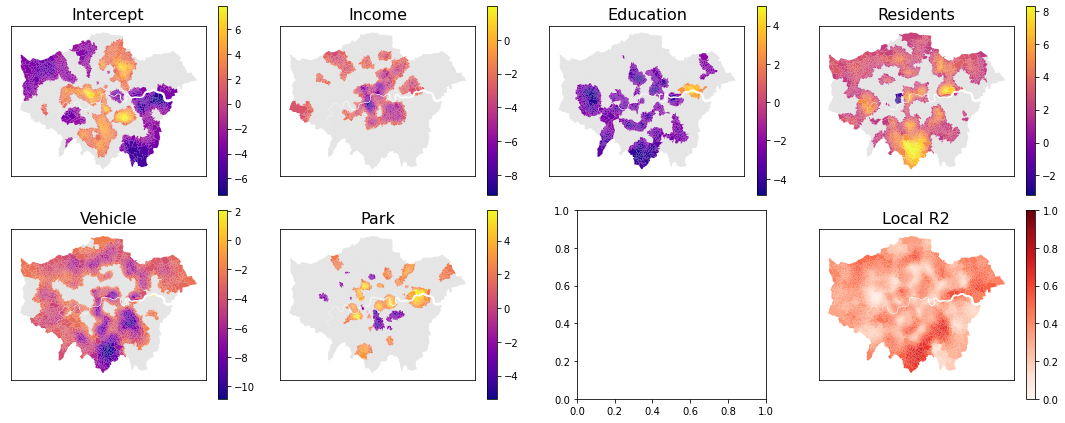

In [145]:
# First, create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,4,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','Income', 'Education', 'Residents', 'Vehicle', 'Park']

# Create loop for our parameter estimates
for i,row in enumerate(filtered_estimates.T):
    # plot all the non-significant estimates in grey
    data_temp = data_final.assign(toplot=filtered_estimates.T[i])
    (data_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))

    # and assign colours only to the significant estimates
    (data_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))

    ax[i].set_title(titles[i], fontsize=16)

    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# map all local R2 regarding the significance

(data_final.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'))

ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])

ax[-1].set_title('Local R2', fontsize=16)


f.tight_layout()

plt.show()

## MGWR Model

In [127]:
#Calibrate MGWR model
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[  32.  232. 4674.  653. 4834. 4834.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [128]:
# Let's print the result
print(mgwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2785.009
Log-likelihood:                                                   -5527.002
AIC:                                                              11066.004
AICc:                                                             11068.027
BIC:                                                             -38182.472
R2:                                                                   0.424
Adj. R2:                                                              0.423

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [134]:
# Filtering only significant result at 0.05 (95% confidence interval)
mgwr_filtered_estimates = mgwr_results.filter_tvals(alpha=.05)

In [135]:
# Convert arrays to data frame
mgwr_data_params = pd.DataFrame(mgwr_filtered_estimates)

In [136]:
# Create the new dataframe
df1_mgwr=pd.DataFrame(merge2['Code'])
df2_mgwr = df1_mgwr.assign(intercept=data_params[0],
                           Density_estimate=data_params[1],
                           IMD_estimate=data_params[2],
                           Education_estimate=data_params[3],
                           Vehicle_estimate=data_params[4],
                           Park_estimate=data_params[5])
df2_mgwr

Code  intercept  Density_estimate  IMD_estimate  \
0     E01000001   0.000000         -5.206913      0.000000   
1     E01000002   0.000000         -5.490392      0.000000   
2     E01000003   0.000000         -4.697259      0.000000   
3     E01000005  -2.081596         -5.811110     -2.842572   
4     E01000006   0.000000         -3.607633      0.000000   
...         ...        ...               ...           ...   
4830  E01033742  -4.820543          0.000000      0.000000   
4831  E01033743  -4.013728         -2.002353      0.000000   
4832  E01033744  -4.862821          0.000000      0.000000   
4833  E01033745  -4.493968          0.000000      0.000000   
4834  E01033746   0.000000         -4.664457      0.000000   

      Education_estimate  Vehicle_estimate  Park_estimate  
0               2.987093         -3.950131       0.000000  
1               3.373757         -4.634147       0.000000  
2               2.513040         -3.731830       0.000000  
3               5.125873         -7.720991       0.000000  
4               3.222996         -5.379699       0.000000  
...                  ...               ...            ...  
4830            0.000000          0.000000       4.100322  
4831            2.153840          0.000000       5.038457  
4832            0.000000          0.000000       3.882629  
4833            0.000000          0.000000       4.707093  
4834            0.000000         -4.043937       0.000000  

[4835 rows x 7 columns]

In [137]:
# Merge our shapefile with the model's results
data_mgwr_final = merge2.merge(df2_mgwr, left_on='Code', right_on='Code')
data_mgwr_final

Code  EnvScore  IncScore  EduScore  USUALRES  vehicle_num  \
0     E01000001      31.9       0.0       0.0      1465        452.0   
1     E01000002      23.1       0.0       0.1      1436        428.0   
2     E01000003      40.5       0.1       5.8      1346        180.0   
3     E01000005      29.0       0.2      22.3       985        124.0   
4     E01000006      26.9       0.1      14.8      1703        493.0   
...         ...       ...       ...       ...       ...          ...   
4830  E01033742      12.5       0.1       7.8      1352        390.0   
4831  E01033743      11.9       0.1       9.2      2038        522.0   
4832  E01033744      14.2       0.2      17.9      1845        429.0   
4833  E01033745      14.8       0.2       9.8      1820        548.0   
4834  E01033746      45.7       0.1       6.4      1464        421.0   

      park_num_avg                                           geometry  \
0        10.410000  POLYGON ((532105.330 182017.386, 532162.728 18...   
1         9.990000  POLYGON ((532747.048 181793.042, 532671.921 18...   
2         9.530000  POLYGON ((532135.385 182204.275, 532158.489 18...   
3        12.240000  POLYGON ((533808.170 180773.910, 533649.287 18...   
4         4.570000  POLYGON ((545122.084 184321.013, 545271.951 18...   
...            ...                                                ...   
4830      2.733333  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831      1.250000  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832      2.419355  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833      2.300000  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834      5.967742  POLYGON ((538140.138 177319.110, 538129.314 17...   

      intercept  Density_estimate  IMD_estimate  Education_estimate  \
0      0.000000         -5.206913      0.000000            2.987093   
1      0.000000         -5.490392      0.000000            3.373757   
2      0.000000         -4.697259      0.000000            2.513040   
3     -2.081596         -5.811110     -2.842572            5.125873   
4      0.000000         -3.607633      0.000000            3.222996   
...         ...               ...           ...                 ...   
4830  -4.820543          0.000000      0.000000            0.000000   
4831  -4.013728         -2.002353      0.000000            2.153840   
4832  -4.862821          0.000000      0.000000            0.000000   
4833  -4.493968          0.000000      0.000000            0.000000   
4834   0.000000         -4.664457      0.000000            0.000000   

      Vehicle_estimate  Park_estimate  
0            -3.950131       0.000000  
1            -4.634147       0.000000  
2            -3.731830       0.000000  
3            -7.720991       0.000000  
4            -5.379699       0.000000  
...                ...            ...  
4830          0.000000       4.100322  
4831          0.000000       5.038457  
4832          0.000000       3.882629  
4833          0.000000       4.707093  
4834         -4.043937       0.000000  

[4835 rows x 14 columns]

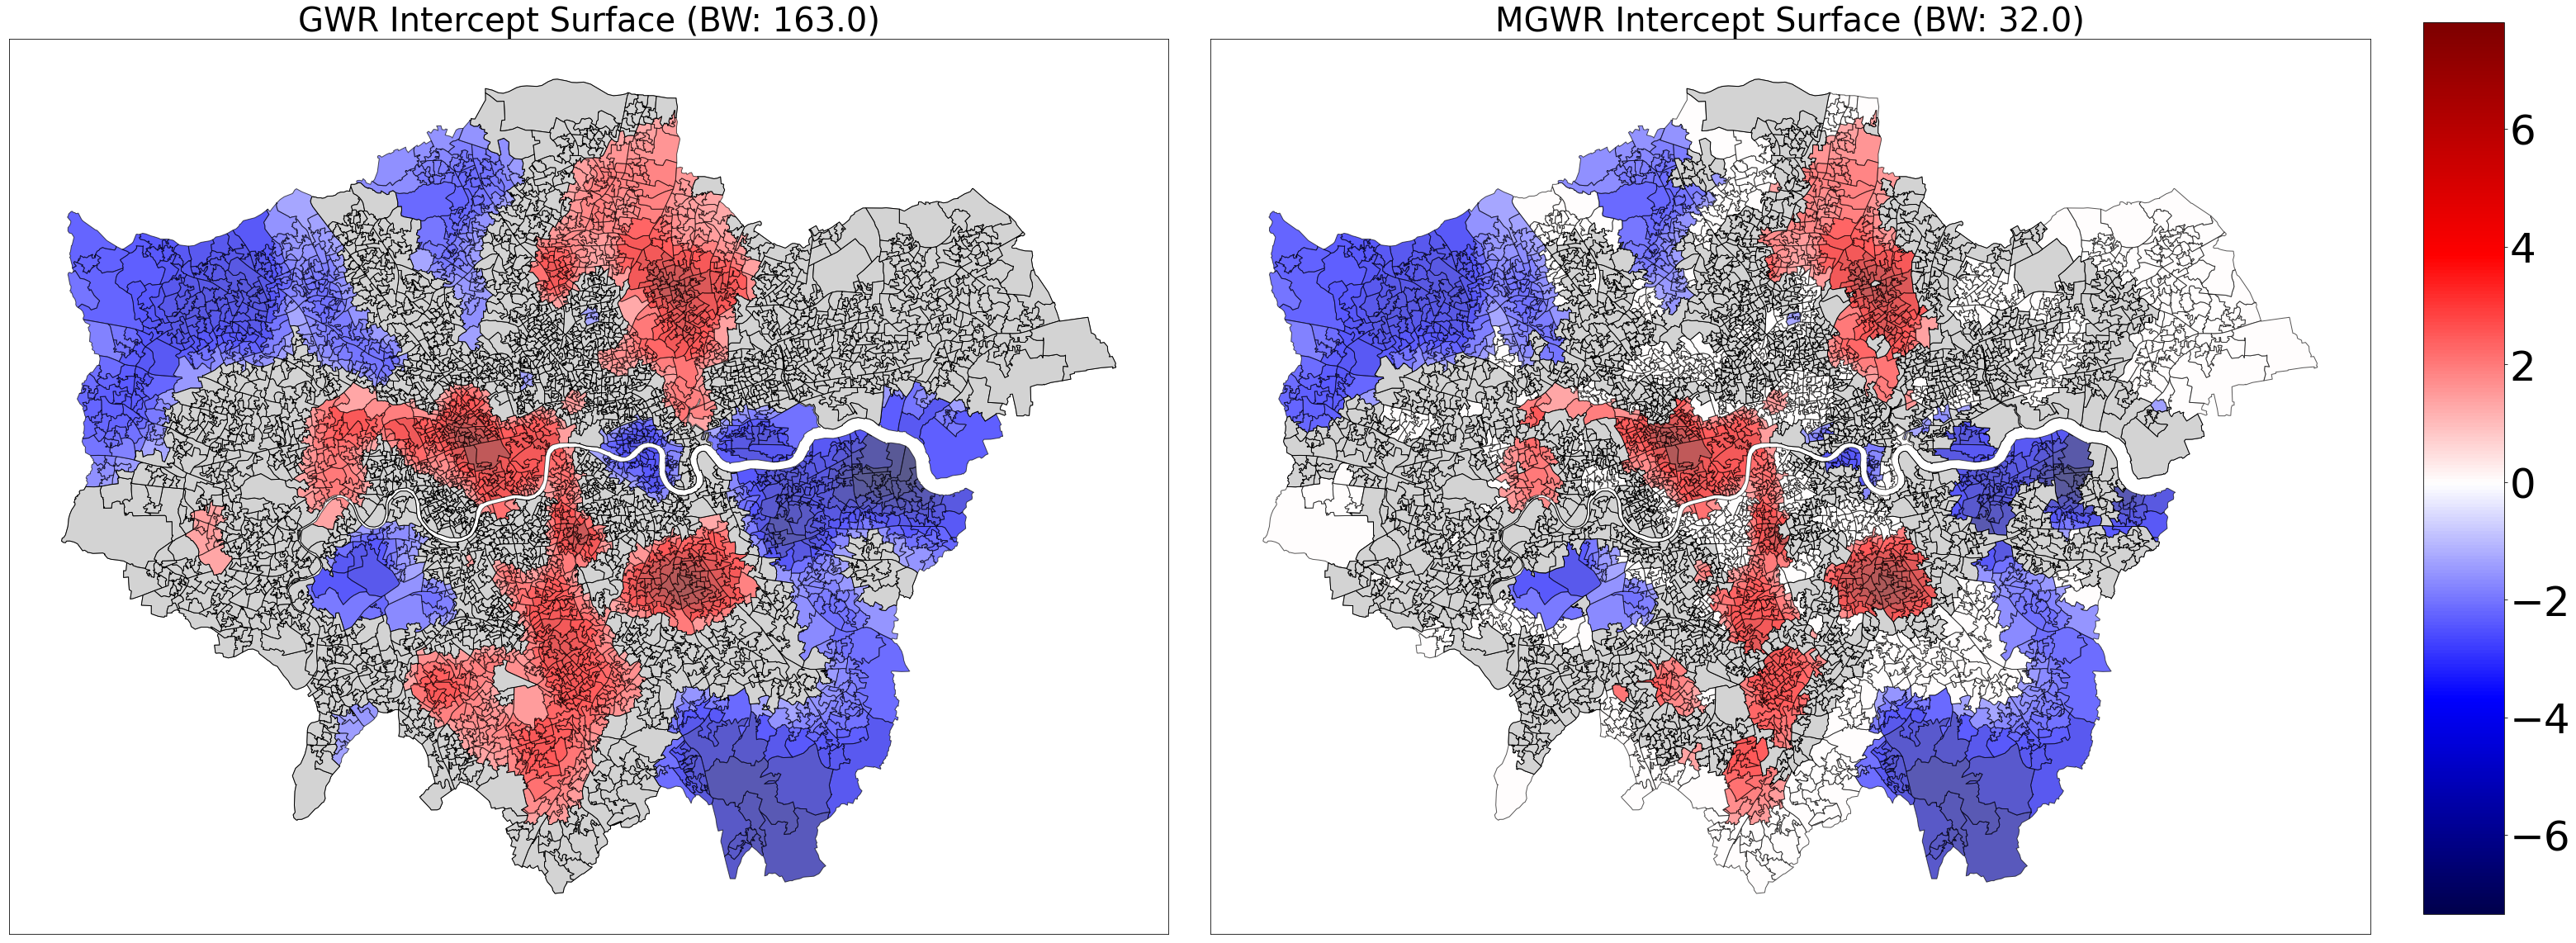

In [138]:
# Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters

# Prep plot and add axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

# Set color map
cmap = plt.cm.seismic

# Find min and max values of the two combined datasets
gwr_min = data_final['intercept'].min()
gwr_max = data_final['intercept'].max()
mgwr_min = data_mgwr_final['intercept'].min()
mgwr_max = data_mgwr_final['intercept'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

# If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
# If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
# Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

# Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Plot GWR parameters
data_final.plot('intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
# If there are insignificnt parameters plot gray polygons over them
if (filtered_estimates[:,0] == 0).any():
    data_final[filtered_estimates[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

# Plot MGWR parameters
data_mgwr_final.plot('intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
# If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_estimates[:,0] == 0).any():
    data_mgwr_final[mgwr_filtered_estimates[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

# Set figure options and plot
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()